In [2]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

edwardotieno_isotropic_phase_path = kagglehub.dataset_download('edwardotieno/isotropic-phase')
edwardotieno_nematic_phase_path = kagglehub.dataset_download('edwardotieno/nematic-phase')
edwardotieno_smectic_phase_path = kagglehub.dataset_download('edwardotieno/smectic-phase')

print('Data source import complete.')


Data source import complete.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
!pip install tensorflow keras numpy matplotlib

In [6]:
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
import os


In [7]:
! pip install imgaug

In [8]:
! pip install albumentations opencv-python


In [9]:
import os

# Print contents of each dataset folder
print("\n📂 Isotropic phase files:")
print(os.listdir(edwardotieno_isotropic_phase_path))

print("\n📂 Nematic phase files:")
print(os.listdir(edwardotieno_nematic_phase_path))

print("\n📂 Smectic phase files:")
print(os.listdir(edwardotieno_smectic_phase_path))



📂 Isotropic phase files:
['5cb_temp_40.00_copy_0009.jpeg', '5cb_temp_39.00_copy_0002.jpeg', '5cb_temp_37.00_copy_0007.jpeg', '5cb_temp_37.00_copy_0004.jpeg', '5cb_temp_39.50_copy_0005.jpeg', '5cb_temp_40.00_copy_0007.jpeg', '5cb_temp_37.00_copy_0006.jpeg', '5cb_temp_36.00_copy_0005.jpeg', '5cb_temp_37.50_copy_0001.jpeg', '5cb_temp_36.00_copy_0001.jpeg', '5cb_temp_37.00_copy_0002.jpeg', '5cb_temp_36.00_copy_0004.jpeg', '5cb_temp_39.00_copy_0003.jpeg', '5cb_temp_37.00_copy_0005.jpeg', '5cb_temp_40.00_copy_0008.jpeg', '5cb_temp_40.00_copy_0003.jpeg', '5cb_temp_37.00_copy_0008.jpeg', '5cb_temp_39.00_copy_0001.jpeg', '5cb_temp_37.50_copy_0004.jpeg', '5cb_temp_37.10_copy_0003.jpeg', '5cb_temp_36.00_copy_0002.jpeg', '5cb_temp_37.00_copy_0009.jpeg', '5cb_temp_40.00_copy_0004.jpeg', '5cb_temp_37.10_copy_0005.jpeg', '5cb_temp_37.50_copy_0002.jpeg', '5cb_temp_39.00_copy_0005.jpeg', '5cb_temp_40.00_copy_0005.jpeg', '5cb_temp_37.00_copy_0010.jpeg', '5cb_temp_36.00_copy_0006.jpeg', '5cb_temp_37.10_

In [10]:
import os
import random
import cv2
import numpy as np
import albumentations as A

# === Paths ===
dataset_5CB_nematic = edwardotieno_nematic_phase_path
dataset_5CB_isotropic =edwardotieno_isotropic_phase_path
dataset_5CB_smectic =edwardotieno_smectic_phase_path
output_path = "/kaggle/working/liquid-crystal-augmented"


# === Categories ===
categories = {
    "nematic": dataset_5CB_nematic,
    "isotropic": dataset_5CB_isotropic,
    "smectic": dataset_5CB_smectic
}

# === Split ratios ===
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# === Create output folders ===
for split in ["train", "val", "test"]:
    for category in categories.keys():
        os.makedirs(os.path.join(output_path, split, category), exist_ok=True)

# === Define augmentation pipeline using Albumentations ===
augmenter = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.7),
    A.RandomScale(scale_limit=0.2, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5)
])

# === Split and augment ===
for category, source_folder in categories.items():
    images = [f for f in os.listdir(source_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    train_split = int(train_ratio * len(images))
    val_split = int(val_ratio * len(images))

    for i, img_name in enumerate(images):
        img_path = os.path.join(source_folder, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print(f"❌ Skipping unreadable image: {img_name}")
            continue

        if i < train_split:
            split = "train"
        elif i < train_split + val_split:
            split = "val"
        else:
            split = "test"

        base_filename = f"{category}_{i}"
        dst_dir = os.path.join(output_path, split, category)

        # Save original image
        original_path = os.path.join(dst_dir, f"{base_filename}_orig.jpg")
        cv2.imwrite(original_path, img)

        # Generate and save 9 augmented versions
        for j in range(9):
            augmented = augmenter(image=img)['image']
            aug_path = os.path.join(dst_dir, f"{base_filename}_aug{j+1}.jpg")
            cv2.imwrite(aug_path, augmented)

        print(f"✅ {split.upper()} - {category} - {img_name} processed")

print(f"\n🎉 Dataset split and augmented successfully at: {output_path}")



/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<ipython-input-10-b375f1ec064e>:36: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),


✅ TRAIN - nematic - 5cb_temp_25.50_copy_0002.jpeg processed
✅ TRAIN - nematic - 5cb_temp_27.50_copy_0002.jpeg processed
✅ TRAIN - nematic - 5cb_temp_26.50_copy_0002.jpeg processed
✅ TRAIN - nematic - 5cb_temp_25.50_copy_0001.jpeg processed
✅ TRAIN - nematic - 5cb_temp_26.50_copy_0001.jpeg processed
✅ TRAIN - nematic - 5cb_temp_25.50_copy_0003.jpeg processed
✅ TRAIN - nematic - 5cb_temp_25.50_copy_0004.jpeg processed
✅ TRAIN - nematic - 5cb_temp_26.50_copy_0004.jpeg processed
✅ TRAIN - nematic - 5cb_temp_27.50_copy_0001.jpeg processed
✅ VAL - nematic - 5cb_temp_25.50_copy_0005.jpeg processed
✅ VAL - nematic - 5cb_temp_27.50_copy_0005.jpeg processed
✅ TEST - nematic - 5cb_temp_27.50_copy_0003.jpeg processed
✅ TEST - nematic - 5cb_temp_27.50_copy_0004.jpeg processed
✅ TEST - nematic - 5cb_temp_26.50_copy_0005.jpeg processed
✅ TRAIN - isotropic - 5cb_temp_37.50_copy_0001.jpeg processed
✅ TRAIN - isotropic - 5cb_temp_39.00_copy_0004.jpeg processed
✅ TRAIN - isotropic - 5cb_temp_37.10_copy_0

In [11]:
print("\n📁 Dataset Split Summary:")
for split in ["train", "val", "test"]:
    print(f"\n🔹 {split.upper()} SET")
    for category in categories.keys():
        folder_path = os.path.join(output_path, split, category)
        num_images = len(os.listdir(folder_path))
        print(f"  - {category}: {num_images} images")


📁 Dataset Split Summary:

🔹 TRAIN SET
  - nematic: 90 images
  - isotropic: 260 images
  - smectic: 760 images

🔹 VAL SET
  - nematic: 20 images
  - isotropic: 70 images
  - smectic: 210 images

🔹 TEST SET
  - nematic: 30 images
  - isotropic: 50 images
  - smectic: 120 images


In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
data_dir = "/kaggle/working/liquid-crystal-augmented"

# Transforms
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
}

Here the images were transformed to tensor after resizing ensuring normalized and reduced computation time with reasonable trainable parameters

In [13]:
datasets_dict = {
    split: datasets.ImageFolder(os.path.join(data_dir, split), transform=transform[split])
    for split in ['train', 'val', 'test']
}

class_names = datasets_dict['train'].classes
print("Classes:", class_names)

Classes: ['isotropic', 'nematic', 'smectic']


In [14]:
label_counts = [0] * len(class_names)
for _, label in datasets_dict['train']:
    label_counts[label] += 1
class_weights = [1.0 / label_counts[label] for _, label in datasets_dict['train']]
sampler = WeightedRandomSampler(class_weights, num_samples=len(class_weights), replacement=True)


unbalanced  dataset for the three class but here we will SMOTE approach to ensure the model treat the classes fairly

In [15]:
# Dataloaders
dataloaders = {
    'train': DataLoader(datasets_dict['train'], batch_size=16, sampler=sampler),
    'val': DataLoader(datasets_dict['val'], batch_size=16, shuffle=False),
    'test': DataLoader(datasets_dict['test'], batch_size=16, shuffle=False)
}


In [16]:
# Model
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)
model.device = device

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
# Loss and Optimizer
weights_tensor = torch.tensor(
    [1.0 / label_counts[i] for i in range(len(class_names))],
    dtype=torch.float
).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [19]:
# Training Loop with live plotting
def train_model(model, epochs=5):
    train_losses, val_accuracies = [], []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss, correct = 0, 0

        for images, labels in dataloaders['train']:
            images, labels = images.to(model.device), labels.to(model.device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

        train_loss = running_loss / len(dataloaders['train'])
        train_acc = correct / len(datasets_dict['train'])
        val_acc = evaluate_model(model, 'val')

        train_losses.append(train_loss)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

In [20]:
# Evaluation Function
def evaluate_model(model, split):
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in dataloaders[split]:
            images, labels = images.to(model.device), labels.to(model.device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    return correct / len(datasets_dict[split])


In [22]:
train_model(model, epochs=1)


Epoch 1/1
Train Loss: 0.0217 | Train Acc: 0.9919 | Val Acc: 1.0000



Test Classification Report:
              precision    recall  f1-score   support

   isotropic       1.00      1.00      1.00        50
     nematic       1.00      1.00      1.00        30
     smectic       1.00      1.00      1.00       120

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

F1 Score (macro): 1.0


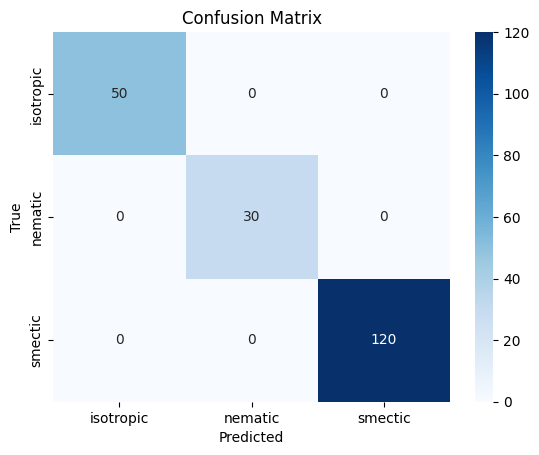

In [23]:
def test_model(model):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloaders['test']:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu())
            all_labels.extend(labels.cpu())

    print("\nTest Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    print("F1 Score (macro):", f1_score(all_labels, all_preds, average='macro'))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, cmap="Blues", fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Run test
test_model(model)


In [24]:
def train_model(model, epochs=1):
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        train_loss, correct = 0, 0

        for images, labels in dataloaders['train']:
            images, labels = images.to(model.device), labels.to(model.device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(output, 1)
            correct += (preds == labels).sum().item()

        avg_train_loss = train_loss / len(dataloaders['train'])
        val_acc = evaluate_model(model, 'val')

        train_losses.append(avg_train_loss)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {correct/len(datasets_dict['train']):.4f} | Val Acc: {val_acc:.4f}")

    return train_losses, val_accuracies

In [25]:
train_losses, val_accuracies = train_model(model, epochs=1)


Epoch 1/1
Train Loss: 0.0054 | Train Acc: 0.9991 | Val Acc: 1.0000


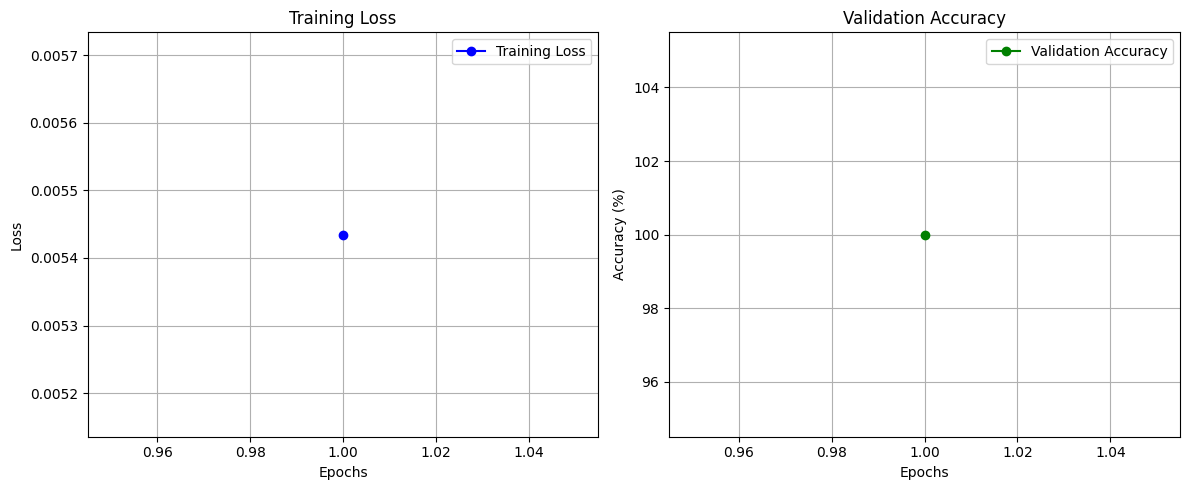

In [26]:
# Plotting training curves
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, 'b-o', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(epochs_range, [acc*100 for acc in val_accuracies], 'g-o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

from the loss plot over epochs -there is gradual spike indicating some hard examples of the liquid crystals phases during training which is reflected on validation accuracy

In [27]:
! pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 532.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.0 MB/s 

In [30]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image


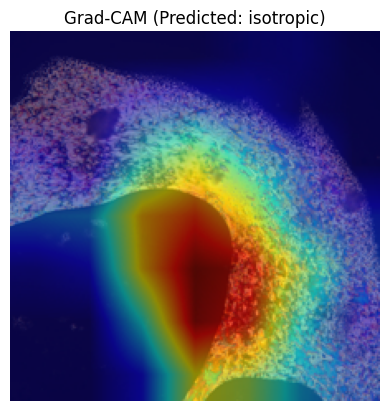

In [35]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# === Load and prepare model ===
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))  # class_names already defined
model = model.to(device)
model.eval()

# === Load image ===
img_path = "/content/5cb_temp_36.00_copy_0001.jpeg"
image = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

input_tensor = transform(image).unsqueeze(0).to(device)

# Normalized image for overlay
rgb_img = np.array(image.resize((224, 224))).astype(np.float32) / 255.0

# Set target layer
target_layers = [model.layer4[-1]]

# Predict class
with torch.no_grad():
    outputs = model(input_tensor)
    pred_class = outputs.argmax().item()

# Set Grad-CAM target
targets = [ClassifierOutputTarget(pred_class)]

# Apply Grad-CAM
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Display
plt.imshow(visualization)
plt.axis("off")
plt.title(f"Grad-CAM (Predicted: {class_names[pred_class]})")
plt.show()
